In [1]:
import numpy as np
import pandas as pd

# For data and graph visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

# Libraries for Machine Learning models and data preprocessing
from sklearn.preprocessing import StandardScaler,scale,Normalizer,OneHotEncoder,RobustScaler,OrdinalEncoder
from sklearn.feature_selection import SelectKBest,VarianceThreshold,chi2,f_classif,mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix,roc_curve, auc,roc_auc_score, precision_score, RocCurveDisplay

# Pipelines
from sklearn.base import BaseEstimator, TransformerMixin,clone
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer
import sklearn
from sklearn.model_selection import StratifiedKFold

# Tools to measure feature importance
from sklearn.inspection import permutation_importance

# Library with predefined functions
import cedenar_anomalies.utils

# Library to handle warnings
import warnings

# Libraries for handling files and directories

# Library to manipulate and store Machine Learning models
from joblib import dump, load

# Library to implement the XGBoost algorithm
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold

import optuna
import optuna.integration.lightgbm as lgb

from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.calibration import CalibrationDisplay

# Setting the random state
rs = {'random_state': 42}

# Setting display options for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

# Configuring graph style
style.use('ggplot')

warnings.filterwarnings('ignore')

In [2]:
import logging
# Configurar logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [3]:
def convert_to_categorical(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        X_copy[col] = X_copy[col].astype('category')
    return X_copy

def do_nothing(df):
    return df

# Crear el transformador de función
convert_type_transformer = FunctionTransformer(convert_to_categorical)
do_nothing_transformer = FunctionTransformer(do_nothing)

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
import pandas as pd
import numpy as np # Asegúrate de importar numpy

# Funciones dummy para que el código sea ejecutable (reemplázalas con tus reales)
def do_nothing(X):
    return X

def convert_to_categorical(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        X_copy[col] = X_copy[col].astype('category')
    return X_copy

def modelLGBM(X_train, X_test, y_train, y_test, **params):

    cat_cols = ['AREA', 'PLAN_COMERCIAL', 'Codigo', 'TRAFO_OPEN'] #'TRAFO_OPEN', 'FASES', 'Codigo'
    numeric_cols = ['LATI_USU', 'LONG_USU'] #'KVA'

    # Es una buena práctica mapear y_train y y_test a 0..n_classes-1 si no lo están ya
    # LGBM a veces lo prefiere, y label_binarize para ROC AUC también lo necesita.
    # Si tus y_train/y_test ya son 0-indexados, puedes omitir esto.
    # Si son 1,2,3,4,5, este mapeo es importante.
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    # classes_ = le.classes_ # Para saber el mapeo original

    # Usar y_train_encoded y y_test_encoded para fit y score

    lgbm_class = LGBMClassifier(verbose=-1, objective='multiclass',class_weight='balanced', random_state=42, **params)

    do_nothing_transformer = FunctionTransformer(do_nothing)
    convert_type_transformer = FunctionTransformer(convert_to_categorical)

    preprocessor = ColumnTransformer(transformers=[
        ('numeric', 'passthrough', numeric_cols),
        ('cat', convert_type_transformer, cat_cols)],
        verbose_feature_names_out=False
    )
    preprocessor.set_output(transform='pandas')

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', lgbm_class)
    ])

    # Asegúrate de que las columnas categóricas en X_train y X_test
    # estén como tipo 'object' o 'string' ANTES de pasarlas al pipeline
    # si 'convert_to_categorical' espera eso. O mejor, haz la conversión
    # a 'category' antes de llamar a modelLGBM.
    # Por simplicidad, asumiré que X_train[cat_cols] ya son adecuadas
    # para convert_to_categorical o que LGBM las manejará.
    # Si LGBM va a manejar categóricas directamente, 'convert_to_categorical'
    # debería asegurar que sean tipo 'category' y pasarlas a LGBM.
    # O, si las dejas como object/string, el FunctionTransformer no es necesario
    # y LGBM las detectará si usas categorical_feature='auto' o las especificas.

    # Para LGBM, es más directo pasar las columnas categóricas como tipo 'category'
    # y dejar que LGBM las maneje. El pipeline podría simplificarse si
    # X_train y X_test ya tienen las columnas categóricas como tipo 'category'.
    # Y las numéricas pueden no necesitar 'do_nothing_transformer'.

    # Ajuste para el entrenamiento:
    # Si tus columnas categóricas ya son tipo 'category' en X_train:
    # pipeline.fit(X_train, y_train_encoded, classifier__categorical_feature=cat_cols)
    # Si usas el preprocesador como está:
    pipeline.fit(X_train, y_train_encoded)


    y_pred = pipeline.predict(X_test) # Esto devolverá etiquetas codificadas 0..N-1

    # Para las métricas, usa y_test_encoded
    fscore = f1_score(y_test_encoded, y_pred, average='weighted')
    pres = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0) # Añadido zero_division
    rcall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0) # Añadido zero_division
    accu = accuracy_score(y_test_encoded, y_pred)

    # --- CAMBIO CLAVE AQUÍ ---
    y_pred_proba_all_classes = pipeline.predict_proba(X_test) # Obtener probabilidades para TODAS las clases

    # Calcular ROC AUC para multiclase
    # Necesitas y_test original (o y_test_encoded binarizado) y todas las probabilidades
    # 'ovo' (One-vs-One) o 'ovr' (One-vs-Rest)
    # 'average' puede ser 'macro' o 'weighted'
    roc_auc = roc_auc_score(
        y_test_encoded, # Usar las etiquetas codificadas 0..N-1
        y_pred_proba_all_classes,
        multi_class='ovr', # o 'ovo'
        average='weighted' # o 'macro'
    )
    # También puedes calcular por clase si lo necesitas después:
    # from sklearn.preprocessing import label_binarize
    # y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(len(le.classes_)))
    # roc_auc_per_class = {}
    # for i, class_label in enumerate(le.classes_):
    #     roc_auc_per_class[class_label] = roc_auc_score(y_test_binarized[:, i], y_pred_proba_all_classes[:, i])
    # print("ROC AUC por clase:", roc_auc_per_class)


    # El DataFrame de scores_data tenía un error de concatenación, lo corrijo
    scores_data = pd.DataFrame({
        'Model': [str(lgbm_class)], # Convertir el objeto modelo a string para el DataFrame
        'F1_Score': [fscore],
        'Precision': [pres],
        'Recall': [rcall],
        'Accuracy': [accu],
        'Roc_auc': [roc_auc]
    })

    return pipeline, scores_data

In [69]:
output_path = "dataset_con_clusters.csv"
df_predicted = pd.read_csv(output_path)
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260800 entries, 0 to 260799
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Orden           260800 non-null  int64  
 1   Usuario         260800 non-null  int64  
 2   Ejecucion       260800 non-null  object 
 3   Codigo          256136 non-null  object 
 4   Descripcion     260800 non-null  object 
 5   Motivo          255439 non-null  object 
 6   kWh Rec         209785 non-null  float64
 7   Factor          3112 non-null    float64
 8   id              250692 non-null  float64
 9   Nombre          250692 non-null  object 
 10  Factor.1        3112 non-null    float64
 11  AREA            260789 non-null  object 
 12  PLAN_COMERCIAL  260789 non-null  object 
 13  TRAFO_OPEN      260658 non-null  object 
 14  FASES           258909 non-null  float64
 15  KVA             260557 non-null  float64
 16  LATI_USU        260557 non-null  float64
 17  LONG_USU  

In [70]:
df_predicted.sample(5)

,Orden,Usuario,Ejecucion,Codigo,Descripcion,Motivo,kWh Rec,Factor,id,Nombre,Factor.1,AREA,PLAN_COMERCIAL,TRAFO_OPEN,FASES,KVA,LATI_USU,LONG_USU,puntaje,evaluacion,Zona,cluster_id,cluster_0,cluster_1,cluster_2
165178,16915930,630519,2022-01-25 17:11:34-05,38,Anomalia verificada con acta digital,Cordillera,728.000,NaN,23.000,ACOMETIDA INTERVENID,NaN,Urbano,2-PLAN RESIDENCIAL,58TA110060,1.000,75.000,1.936,-77.308,5.000,3.000,NO,2,0.005,0.018,0.977
20030,19407044,1178774,2022-06-02 16:34:44-05,39,Anomalia verificada con acta digital,Pie De Monte,NaN,NaN,47.000,SERVICIO DIRECTO(MEDIDOR CON USUARIO),NaN,Rural,2-PLAN RESIDENCIAL,05TN000362,1.000,75.000,1.699,-78.248,4.000,3.000,PA,1,0.038,0.957,0.005
27658,20247584,384414,2022-07-21 08:32:12-05,82,Anomalia verificada y aprobada,Destacados Flash,1136.000,NaN,78.000,SE CORRIGE MEDIDOR FUERA DE SOCKET Y/O,NaN,Urbano,2-PLAN RESIDENCIAL,60TN030007,1.000,75.000,1.807,-78.775,2.000,2.000,PA,0,0.998,0.001,0.001
57493,25503489,1268477,2023-04-18 08:33:13-05,38,Anomalia verificada con acta digital,No Existe Anomalía En El Acta,0.000,NaN,34.000,CONEXIÓN EN BORNES CONFORME,NaN,Urbano,2-PLAN RESIDENCIAL,05TN000147,1.000,112.500,1.668,-78.142,2.000,2.000,PA,1,0.019,0.978,0.004
32976,20941031,1079226,2022-08-26 10:51:39-05,30001,Anomalia verificada y aprobada,Luminaria Encendida,199.000,NaN,63.000,OTRAS ANOMALÍAS QUE PUEDEN DETECTARSE Y,NaN,Urbano,2-PLAN RESIDENCIAL,05TN000134,1.000,75.000,1.671,-78.140,2.000,2.000,PA,1,0.020,0.976,0.004


In [71]:
df_predicted = df_predicted.dropna(subset=['puntaje'])

# Crea la columna combinada para la estratificación
# Convertir a string para asegurar que la concatenación funcione bien
df_predicted['puntaje_zona_stratify'] = df_predicted['puntaje'].astype(str) + "_" + df_predicted['Zona'].astype(str)
# Verificar la distribución de esta nueva columna
logger.info("Distribución de la columna de estratificación combinada:")
logger.info(df_predicted['puntaje_zona_stratify'].value_counts(normalize=True) * 100)

# Definir tus features (X) y target (y) desde el DataFrame filtrado df_knn_stratify
df_predicted['cluster_id'] = df_predicted['cluster_id'].astype(str)
feature_cols = ['LATI_USU', 'LONG_USU', 'AREA', 'PLAN_COMERCIAL', 'cluster_id'] # Las que usará KNN
target_col = 'puntaje'

X = df_predicted
y = df_predicted[target_col].astype(int) # El target para KNN
stratify_col = df_predicted['puntaje_zona_stratify']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,       # 80% entrenamiento, 20% prueba
    random_state=42,      # Para reproducibilidad
    stratify=stratify_col # ¡Aquí se usa la columna combinada!
)
X_train_group = X_train["puntaje_zona_stratify"].copy()
X_test_group = X_test["puntaje_zona_stratify"].copy()

logger.info(f"\nTamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
logger.info(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")

# Puedes verificar la estratificación (opcional pero recomendado)
logger.info("\nDistribución del target 'puntaje' en el conjunto de entrenamiento:")
logger.info(y_train.value_counts(normalize=True) * 100)
logger.info("\nDistribución del target 'puntaje' en el conjunto de prueba:")
logger.info(y_test.value_counts(normalize=True) * 100)

2025-06-03 12:15:17,701 - INFO - Distribución de la columna de estratificación combinada:
2025-06-03 12:15:17,709 - INFO - puntaje_zona_stratify
5.0_PA   19.502
5.0_NO   14.846
1.0_PA   11.666
2.0_PA   10.333
1.0_NO    8.133
2.0_NO    7.774
5.0_OC    3.301
5.0_CE    2.818
5.0_SU    2.811
4.0_PA    2.808
4.0_CE    2.348
1.0_CE    2.344
1.0_OC    1.839
2.0_OC    1.700
1.0_SU    1.567
2.0_SU    1.466
2.0_CE    1.349
3.0_PA    0.972
3.0_CE    0.969
4.0_SU    0.389
4.0_NO    0.368
3.0_NO    0.338
3.0_SU    0.150
4.0_OC    0.138
3.0_OC    0.072
Name: proportion, dtype: float64
2025-06-03 12:15:17,867 - INFO - 
Tamaño del conjunto de entrenamiento (X_train): (200553, 26)
2025-06-03 12:15:17,868 - INFO - Tamaño del conjunto de prueba (X_test): (50139, 26)
2025-06-03 12:15:17,868 - INFO - 
Distribución del target 'puntaje' en el conjunto de entrenamiento:
2025-06-03 12:15:17,869 - INFO - puntaje
5   43.278
1   25.548
2   22.623
4    6.050
3    2.500
Name: proportion, dtype: float64
2025-06-03 1

In [86]:
# we train and evaluate different models
pipelines, scores_df = modelLGBM(X_train, X_test, y_train, y_test)

In [87]:
pipelines.named_steps['classifier'].feature_importances_

array([3423, 3045,  209,  274,   57, 1624, 6368], dtype=int32)

In [88]:
pipelines[1].get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'multiclass',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'is_unbalance': True}

In [89]:
scores_df

,Model,F1_Score,Precision,Recall,Accuracy,Roc_auc
0,"LGBMClassifier(class_weight='balanced', is_unb...",0.354,0.404,0.362,0.362,0.597


In [95]:
cat_cols = ['AREA', 'PLAN_COMERCIAL', 'TRAFO_OPEN', 'Codigo']
numeric_cols = ['LATI_USU', 'LONG_USU']

In [112]:
def lgt_pipeline(**params):
    group_kfold = StratifiedKFold(n_splits=n_splits,shuffle=True)

    # pipeline
    model_ht = LGBMClassifier(n_jobs=-1,verbosity=-1, random_state=42, eval_metric="auc", objective='multiclass', class_weight='balanced', **params)

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', do_nothing_transformer, numeric_cols),
            ('cat', convert_type_transformer, cat_cols)
        ]
    )

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', model_ht)
        ]
    )

    return pipeline

In [98]:
n_splits = 5
alpha = .3
def objective(trial):
    global X_train, y_train # Hacemos explícito que usamos las globales, o pásalas como argumento

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 700),
        "learning_rate": trial.suggest_float('learning_rate', 0.001, 0.1, log=True), # Cambiado a float y log=True
        "num_leaves": trial.suggest_int("num_leaves", 30, 300), # Rango ajustado, 2500 puede ser muy alto
        "max_depth": trial.suggest_int("max_depth", 3, 12), # Rango ajustado
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100), # Renombrado y rango ajustado
        "max_bin": trial.suggest_int("max_bin", 100, 300), # Rango ajustado
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True), # Cambiado a float
        "reg_lambda": trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True), # Cambiado a float
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float('bagging_fraction', 0.5, 1.0), # Cambiado a float
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "feature_fraction": trial.suggest_float('feature_fraction', 0.5, 1.0) # Cambiado a float
        # "colsample_bytree": trial.suggest_float('colsample_bytree', 0.5, 1.0) # Alternativa a feature_fraction
    }

    # Asegúrate de que y_train sea 1D (Series o array numpy) para StratifiedKFold
    # y que X_train_group sea lo que quieres usar para la estratificación.
    # Si X_train_group no está definido, usa y_train.
    # Asumiré que quieres estratificar por y_train:
    group_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # Añadido random_state

    pipeline_obj = lgt_pipeline(**params) # Renombrado para evitar confusión con el módulo pipeline

    scores = []

    # Codificar y_train a 0..N-1 si no lo está ya. LGBM lo prefiere.
    # Y roc_auc_score con multi_class='ovr' también lo espera así para y_true.
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train) # Asumiendo que y_train es una Serie/array de etiquetas originales

    # Loop
    for train_idx, fold_idx in group_kfold.split(X_train, y_train_encoded): # Usar y_train_encoded para el split
        X_train_, X_fold = X_train.iloc[train_idx], X_train.iloc[fold_idx]
        y_train_loop, y_fold_loop = y_train_encoded[train_idx], y_train_encoded[fold_idx] # Usar las etiquetas codificadas

        model_loop = clone(pipeline_obj)

        # Para LGBM, si usas callbacks o eval_set, necesitarías pasar X_fold, y_fold_loop
        # Aquí, solo hacemos fit.
        # Si tus columnas categóricas ya son tipo 'category' en X_train_:
        # model_loop.fit(X_train_, y_train_loop, classifier__categorical_feature=cat_cols)
        # Si el preprocesador las maneja:
        model_loop.fit(X_train_, y_train_loop)

        # --- CAMBIO CLAVE AQUÍ ---
        y_train_pred_proba = model_loop.predict_proba(X_train_) # Array (n_muestras, n_clases)
        y_fold_pred_proba = model_loop.predict_proba(X_fold)   # Array (n_muestras, n_clases)

        # Usar las etiquetas codificadas para roc_auc_score
        auc_train = roc_auc_score(y_train_loop, y_train_pred_proba, multi_class='ovr', average='weighted')
        auc_fold = roc_auc_score(y_fold_loop, y_fold_pred_proba, multi_class='ovr', average='weighted')
        scores.append((auc_train, auc_fold))

    scores_df = pd.DataFrame(scores, columns=["train_score", "fold_score"]) # Renombrado a scores_df

    # Tu métrica objetivo personalizada
    fold_score_mean = scores_df.fold_score.mean()
    fold_score_std = scores_df.fold_score.std()
    overfit_penalty = (scores_df.train_score.mean() - fold_score_mean) * alpha # Penalizar overfitting

    # Queremos maximizar el fold_score, minimizar su std, y minimizar el overfitting
    # Si alpha es positivo, un overfit_penalty más grande reduce el score.
    # Asegúrate de que la dirección de la optimización ('maximize') sea coherente.
    # Si el overfit_penalty es negativo (train_score < fold_score_mean), esto aumentaría el valor, lo cual es raro.
    # Normalmente, train_score >= fold_score_mean.

    # Si la std es muy pequeña o NaN (e.g., n_splits=1), maneja el caso
    if pd.isna(fold_score_std):
        fold_score_std = 0

    objective_value = fold_score_mean - (fold_score_std * (1 - alpha)) - overfit_penalty
    return objective_value

In [99]:
def callback(study, trial):
    if trial.number > 0 and trial.number % 10 == 0: # Ajustado para no imprimir en trial 0 y frecuencia
        # logger.info(f"Trial {trial.number}: Value={trial.value}, Params={trial.params}")
        if study.best_trial:
            logger.info(f"After: {trial.number} trials | best value: {round(study.best_value,4)} | best trial: {study.best_trial.number}")
        else:
            logger.info(f"After: {trial.number} trials | No best trial yet.")

In [100]:
%%time
n_trials = 300
optuna.logging.get_logger("optuna").setLevel(logging.WARNING)

study = optuna.create_study(direction='maximize', study_name="LGBM Classifier")
study.optimize(objective, n_trials=n_trials,callbacks=[callback])

2025-06-03 12:43:09,421 - INFO - After: 10 trials | best value: 0.6739 | best trial: 5
2025-06-03 12:49:40,192 - INFO - After: 20 trials | best value: 0.6746 | best trial: 11
2025-06-03 12:56:06,378 - INFO - After: 30 trials | best value: 0.6764 | best trial: 24
2025-06-03 13:03:22,815 - INFO - After: 40 trials | best value: 0.6764 | best trial: 24
2025-06-03 13:10:56,207 - INFO - After: 50 trials | best value: 0.6764 | best trial: 45
2025-06-03 13:16:54,762 - INFO - After: 60 trials | best value: 0.6802 | best trial: 60
2025-06-03 13:20:01,417 - INFO - After: 70 trials | best value: 0.6803 | best trial: 62
2025-06-03 13:22:19,016 - INFO - After: 80 trials | best value: 0.6804 | best trial: 75
2025-06-03 13:24:22,010 - INFO - After: 90 trials | best value: 0.6804 | best trial: 75
2025-06-03 13:26:10,426 - INFO - After: 100 trials | best value: 0.6804 | best trial: 75
2025-06-03 13:28:17,218 - INFO - After: 110 trials | best value: 0.6804 | best trial: 75
2025-06-03 13:31:19,878 - INFO 

CPU times: user 5h 35min 8s, sys: 2h 9min 37s, total: 7h 44min 46s
Wall time: 2h 14min 11s


In [101]:
# Muestra los mejores hiperparámetros y puntuación AUC en test
best_params = study.best_params
best_auc = study.best_value
print('Best AUC:', round(best_auc,3))
K = 3
res = dict()
for key in best_params:
    res[key] = round(best_params[key], K)

print('Best params:', res)

Best AUC: 0.684
Best params: {'n_estimators': 138, 'learning_rate': 0.002, 'num_leaves': 184, 'max_depth': 3, 'min_child_samples': 75, 'max_bin': 145, 'reg_alpha': 0.002, 'reg_lambda': 3.794, 'min_gain_to_split': 13.483, 'bagging_fraction': 0.984, 'bagging_freq': 4, 'feature_fraction': 1.0}


In [103]:
best_params ={'n_estimators': 114, 'learning_rate': 0.001, 'num_leaves': 173, 'max_depth': 3, 'min_child_samples': 19, 'max_bin': 138, 'reg_alpha': 8.767, 'reg_lambda': 0.005, 'min_gain_to_split': 3.028, 'bagging_fraction': 0.942, 'bagging_freq': 8, 'feature_fraction': 0.946}

In [102]:
best_params = res

In [121]:
pipelines, scores_df = modelLGBM(X_train, X_test, y_train, y_test, **best_params) #

In [122]:
scores_df

,Model,F1_Score,Precision,Recall,Accuracy,Roc_auc
0,"LGBMClassifier(bagging_fraction=0.984, bagging...",0.301,0.804,0.376,0.376,0.687


In [123]:
y_pred_train = pipelines.predict_proba(X_train)
y_pred_test = pipelines.predict_proba(X_test)

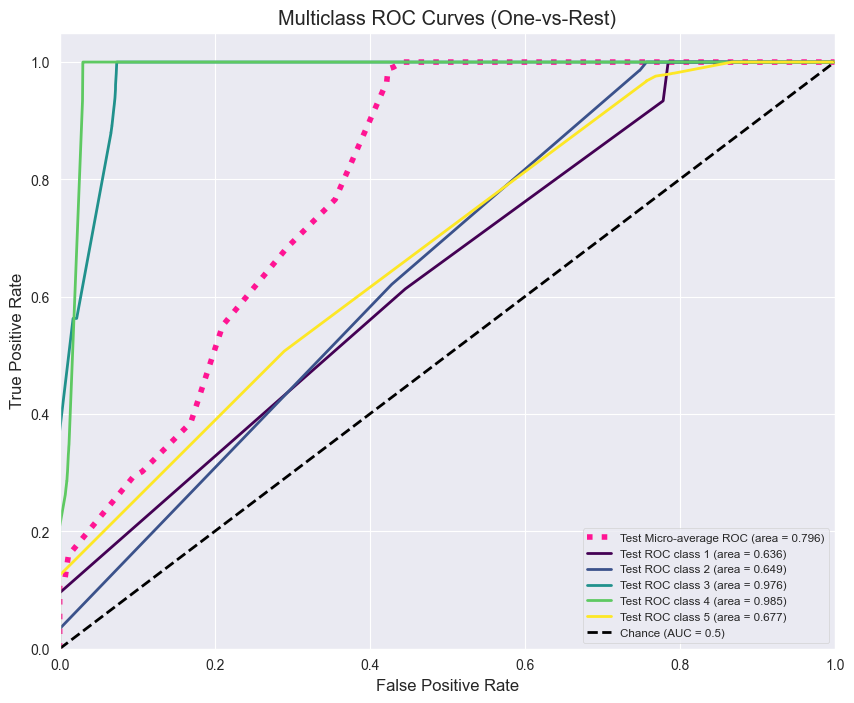

Test AUC ROC por clase: {1: 0.6364857097309868, 2: 0.6489072208538273, 3: 0.9758308281046931, 4: 0.9847655103953307, 5: 0.6774975957475575}
Test Micro-Average AUC ROC: 0.7962


In [124]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Asume y_train son las etiquetas originales
y_test_encoded = le.transform(y_test)     # Asume y_test son las etiquetas originales
current_classes = le.classes_ # Clases originales en el orden de codificación
n_classes = len(current_classes)

# Binarizar las etiquetas
y_train_binarized = label_binarize(y_train_encoded, classes=np.arange(n_classes))
y_test_binarized = label_binarize(y_test_encoded, classes=np.arange(n_classes))

# --- Curvas ROC y AUC por clase para PRUEBA ---
fpr_test_dict = dict()
tpr_test_dict = dict()
roc_auc_test_dict = dict()

for i in range(n_classes):
    fpr_test_dict[i], tpr_test_dict[i], _ = roc_curve(y_test_binarized[:, i], y_pred_test[:, i])
    roc_auc_test_dict[i] = auc(fpr_test_dict[i], tpr_test_dict[i])

# --- Curva ROC Micro-Promediada para PRUEBA ---
fpr_test_micro, tpr_test_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_test.ravel())
roc_auc_test_micro = auc(fpr_test_micro, tpr_test_micro)

# --- (Opcional) Curvas ROC y AUC por clase para ENTRENAMIENTO ---
fpr_train_dict = dict()
tpr_train_dict = dict()
roc_auc_train_dict = dict()
for i in range(n_classes):
    fpr_train_dict[i], tpr_train_dict[i], _ = roc_curve(y_train_binarized[:, i], y_pred_train[:, i])
    roc_auc_train_dict[i] = auc(fpr_train_dict[i], tpr_train_dict[i])

fpr_train_micro, tpr_train_micro, _ = roc_curve(y_train_binarized.ravel(), y_pred_train.ravel())
roc_auc_train_micro = auc(fpr_train_micro, tpr_train_micro)


# --- Graficar ---
plt.figure(figsize=(10, 8))
lw = 2

# Curva Micro-promediada de Prueba
plt.plot(
    fpr_test_micro,
    tpr_test_micro,
    label=f"Test Micro-average ROC (area = {roc_auc_test_micro:0.3f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Curvas por clase para Prueba
colors = plt.cm.get_cmap('viridis', n_classes)
for i in range(n_classes):
    plt.plot(
        fpr_test_dict[i],
        tpr_test_dict[i],
        color=colors(i / n_classes),
        lw=lw,
        label=f"Test ROC class {current_classes[i]} (area = {roc_auc_test_dict[i]:0.3f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw, label="Chance (AUC = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()

# Imprimir AUCs
print("Test AUC ROC por clase:", {current_classes[i]: roc_auc_test_dict[i] for i in range(n_classes)})
print(f"Test Micro-Average AUC ROC: {roc_auc_test_micro:.4f}")

Generando curvas de calibración para el conjunto de ENTRENAMIENTO:


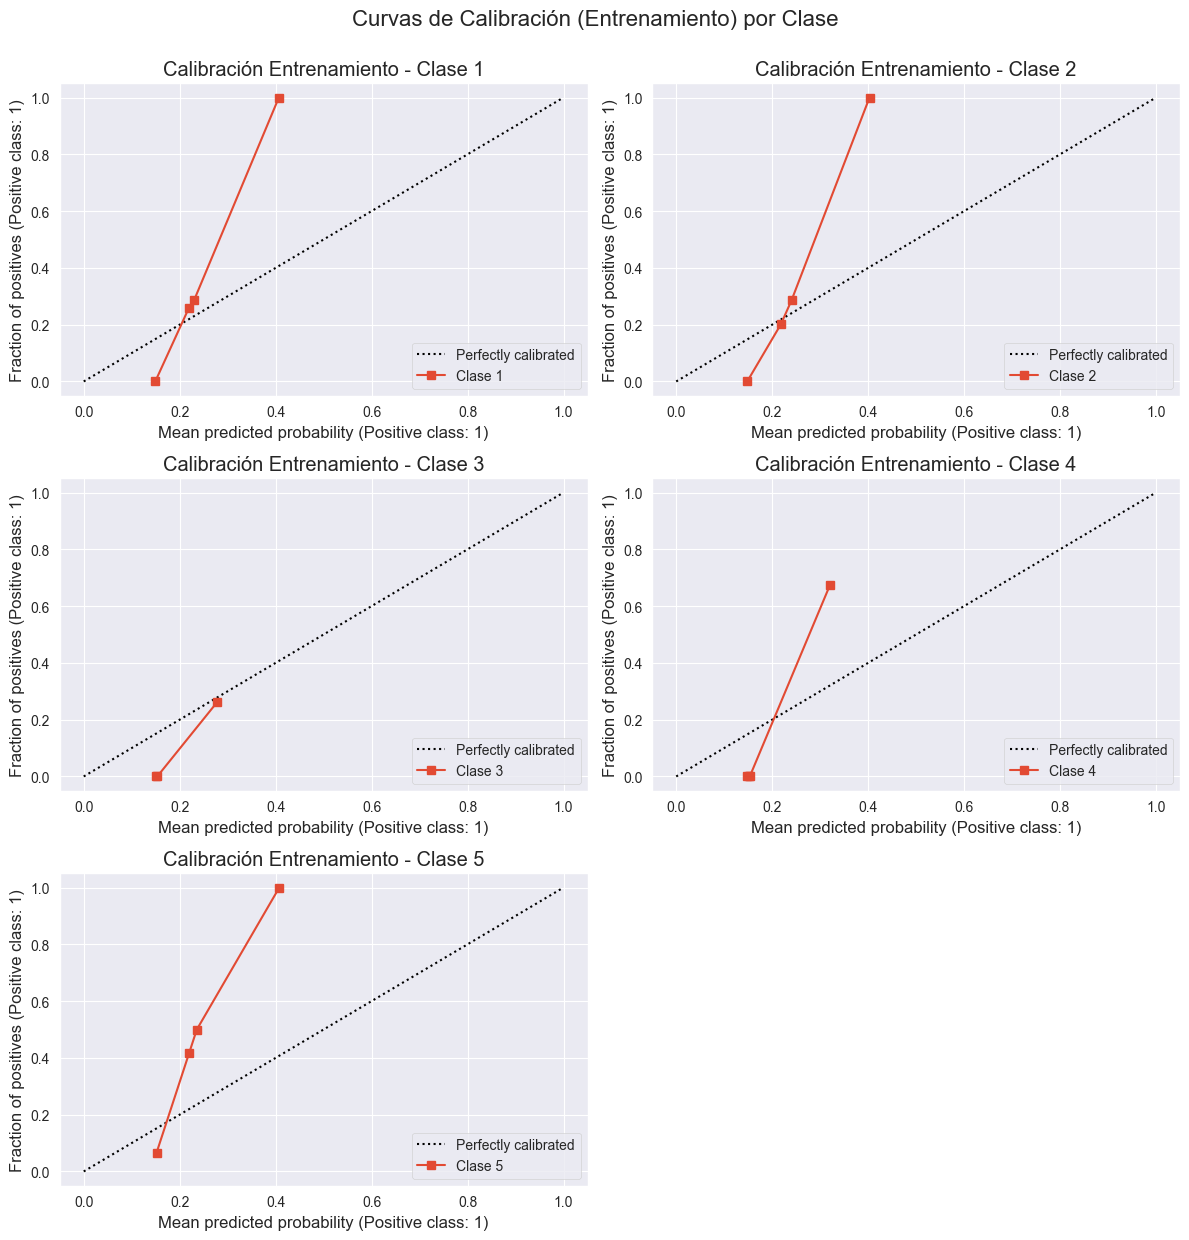

In [125]:
from sklearn.calibration import CalibrationDisplay, calibration_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize # Ya deberías tenerla importada

# Asegúrate de que y_train e y_test estén codificadas de 0 a n_classes-1 si es necesario
# Si tus clases son, por ejemplo, [1, 2, 3, 4, 5], necesitas mapearlas.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Asume y_train son las etiquetas originales
# y_test_encoded = le.transform(y_test) # No se usa en este fragmento, pero bueno tenerlo
current_classes_original_labels = le.classes_ # Etiquetas originales como [1, 2, 3, 4, 5]
n_classes = len(current_classes_original_labels)
# Las clases codificadas serán np.arange(n_classes), es decir, [0, 1, 2, 3, 4]

# Binarizar y_train_encoded para el enfoque One-vs-Rest
# Esto crea una matriz donde cada columna es una clase, y las entradas son 0 o 1.
y_train_binarized_for_calibration = label_binarize(y_train_encoded, classes=np.arange(n_classes))


# --- Graficar Curvas de Calibración por Clase para el Conjunto de ENTRENAMIENTO ---
n_cols_plot = 2
n_rows_plot = int(np.ceil(n_classes / n_cols_plot))
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(12, 4 * n_rows_plot))
axes = axes.flatten() # Aplanar para iterar fácilmente

print("Generando curvas de calibración para el conjunto de ENTRENAMIENTO:")

for i in range(n_classes):
    ax = axes[i]

    # y_true para esta clase específica (un array 1D binario)
    y_true_class_i = y_train_binarized_for_calibration[:, i]

    # y_prob para esta clase específica (un array 1D de probabilidades)
    y_prob_class_i = y_pred_train[:, i]

    # El nombre de la clase original para el título
    class_name_original = current_classes_original_labels[i]

    try:
        disp = CalibrationDisplay.from_predictions(
            y_true_class_i,
            y_prob_class_i,
            n_bins=10,
            strategy="quantile", # o "uniform"
            # pos_label=1, # No es necesario si y_true_class_i ya es 0/1
            name=f"Clase {class_name_original}", # Nombre para la leyenda
            ax=ax
        )
        ax.set_title(f"Calibración Entrenamiento - Clase {class_name_original}")
    except ValueError as e:
        # Puede ocurrir si una clase no tiene suficientes muestras positivas o negativas
        # o si todas las probabilidades predichas son idénticas.
        ax.text(0.5, 0.5, f"No se pudo generar para Clase {class_name_original}\n{e}",
                horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"Calibración Entrenamiento - Clase {class_name_original}")
        print(f"  Advertencia: No se pudo generar curva de calibración para Clase {class_name_original}: {e}")

# Ocultar ejes no utilizados
for j in range(i + 1, n_rows_plot * n_cols_plot):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Curvas de Calibración (Entrenamiento) por Clase", fontsize=16, y=1.03)
plt.show()



Generando curvas de calibración para el conjunto de PRUEBA:


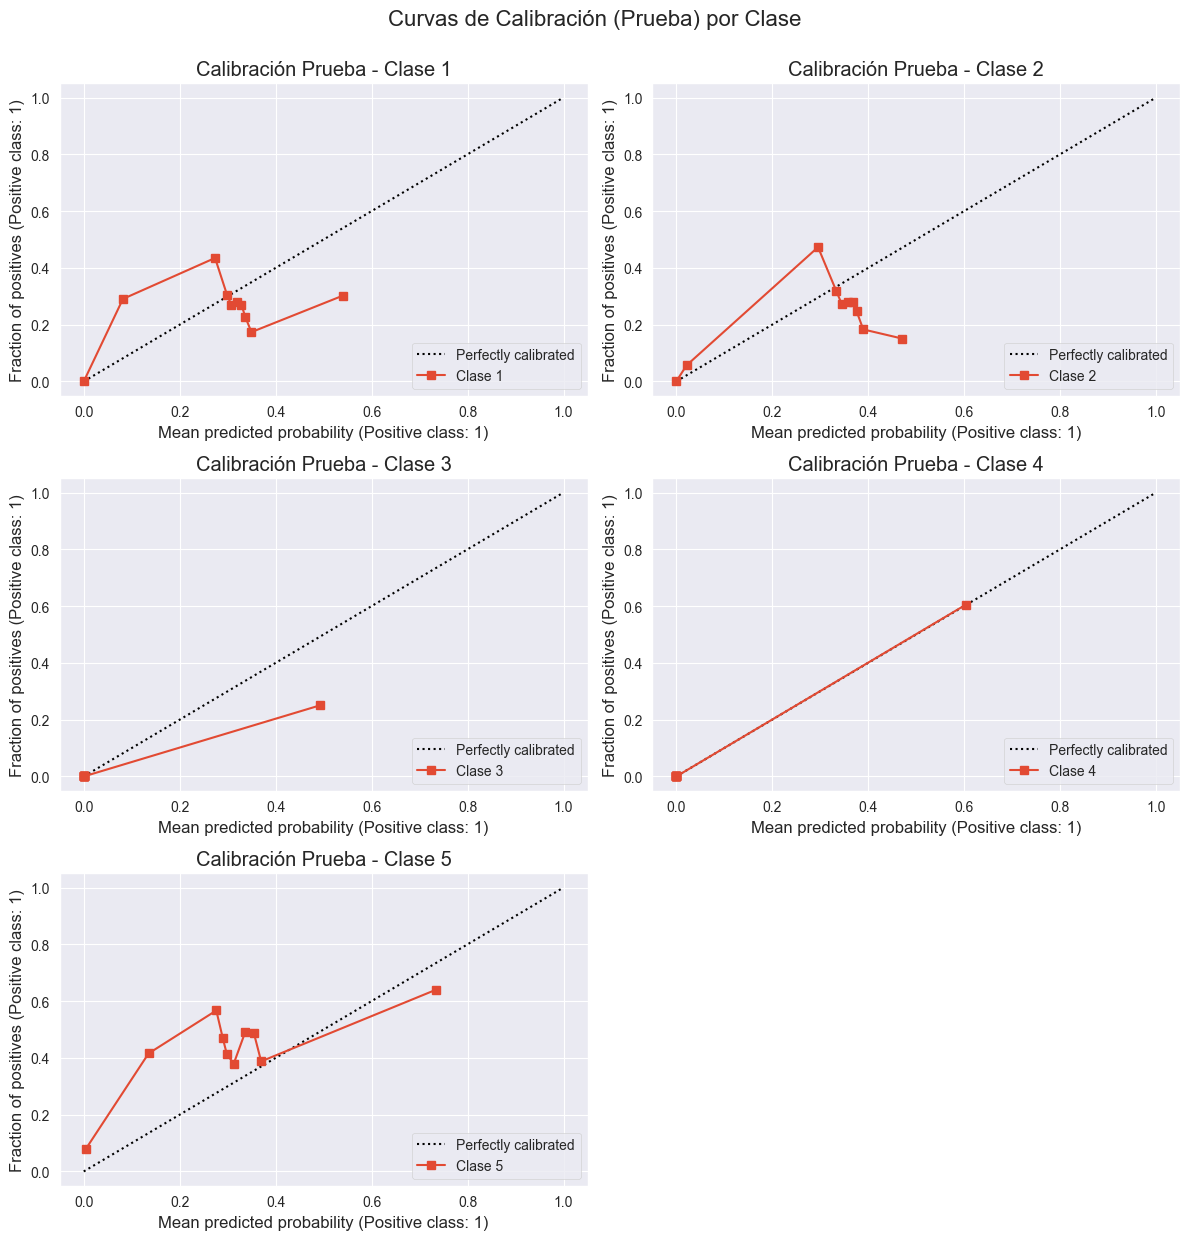

In [126]:
#--- Puedes hacer lo mismo para el conjunto de PRUEBA ---
y_test_binarized_for_calibration = label_binarize(y_test_encoded, classes=np.arange(n_classes))
fig_test, axes_test = plt.subplots(n_rows_plot, n_cols_plot, figsize=(12, 4 * n_rows_plot))
axes_test = axes_test.flatten()
print("\nGenerando curvas de calibración para el conjunto de PRUEBA:")
for i in range(n_classes):
    ax_t = axes_test[i]
    y_true_class_i_test = y_test_binarized_for_calibration[:, i]
    y_prob_class_i_test = y_proba_test[:, i]
    class_name_original = current_classes_original_labels[i]
    try:
        disp_test = CalibrationDisplay.from_predictions(
            y_true_class_i_test,
            y_prob_class_i_test,
            n_bins=10,
            strategy="quantile",
            name=f"Clase {class_name_original}",
            ax=ax_t
        )
        ax_t.set_title(f"Calibración Prueba - Clase {class_name_original}")
    except ValueError as e:
        ax_t.text(0.5, 0.5, f"No se pudo generar para Clase {class_name_original}\n{e}",
                horizontalalignment='center', verticalalignment='center', transform=ax_t.transAxes)
        ax_t.set_title(f"Calibración Prueba - Clase {class_name_original}")
        print(f"  Advertencia: No se pudo generar curva de calibración para Clase {class_name_original} (Prueba): {e}")
for j in range(i + 1, n_rows_plot * n_cols_plot):
    fig_test.delaxes(axes_test[j])
plt.tight_layout()
plt.suptitle("Curvas de Calibración (Prueba) por Clase", fontsize=16, y=1.03)
plt.show()

In [127]:
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas para el conjunto de prueba
y_proba_train = pipelines.predict_proba(X_train)
y_proba_test = pipelines.predict_proba(X_test)

# TRAIN
# Calcular ROC-AUC OvR ponderado
# Nota: y_test debe estar en su formato original, y_proba_test son las probabilidades
roc_auc_test_weighted = roc_auc_score(y_train, y_proba_train, multi_class='ovr', average='weighted')
print(f"TRAIN \nROC-AUC (OvR Ponderado) en Test: {roc_auc_test_weighted:.4f}")

# Calcular ROC-AUC para cada clase (One-vs-Rest)
print("ROC-AUC por clase (OvR) en Test:")
for i, class_label in enumerate(pipelines.classes_):
    class_label = class_label+1
    # Necesitas binarizar y_test para cada clase
    y_train_binarized = (y_train == class_label).astype(int)
    roc_auc_class = roc_auc_score(y_train_binarized, y_proba_train[:, i])
    print(f"  Puntaje {class_label}: {roc_auc_class:.4f}")

# TEST
# Calcular ROC-AUC OvR ponderado
# Nota: y_test debe estar en su formato original, y_proba_test son las probabilidades
roc_auc_test_weighted = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
print(f"TEST \nROC-AUC (OvR Ponderado) en Test: {roc_auc_test_weighted:.4f}")

# Calcular ROC-AUC para cada clase (One-vs-Rest)
print("\nROC-AUC por clase (OvR) en Test:")
for i, class_label in enumerate(pipelines.classes_):
    class_label = class_label+1
    # Necesitas binarizar y_test para cada clase
    y_test_binarized = (y_test == class_label).astype(int)
    roc_auc_class = roc_auc_score(y_test_binarized, y_proba_test[:, i])
    print(f"  Puntaje {class_label}: {roc_auc_class:.4f}")

TRAIN 
ROC-AUC (OvR Ponderado) en Test: 0.6859
ROC-AUC por clase (OvR) en Test:
  Puntaje 1: 0.6375
  Puntaje 2: 0.6473
  Puntaje 3: 0.9800
  Puntaje 4: 0.9867
  Puntaje 5: 0.6757
TEST 
ROC-AUC (OvR Ponderado) en Test: 0.6866

ROC-AUC por clase (OvR) en Test:
  Puntaje 1: 0.6365
  Puntaje 2: 0.6489
  Puntaje 3: 0.9758
  Puntaje 4: 0.9848
  Puntaje 5: 0.6775


Generando gráficos de Precisión y Recall vs. Umbral por clase...
  Gráfico para Puntaje 1 generado.
  Gráfico para Puntaje 2 generado.
  Gráfico para Puntaje 3 generado.
  Gráfico para Puntaje 4 generado.
  Gráfico para Puntaje 5 generado.


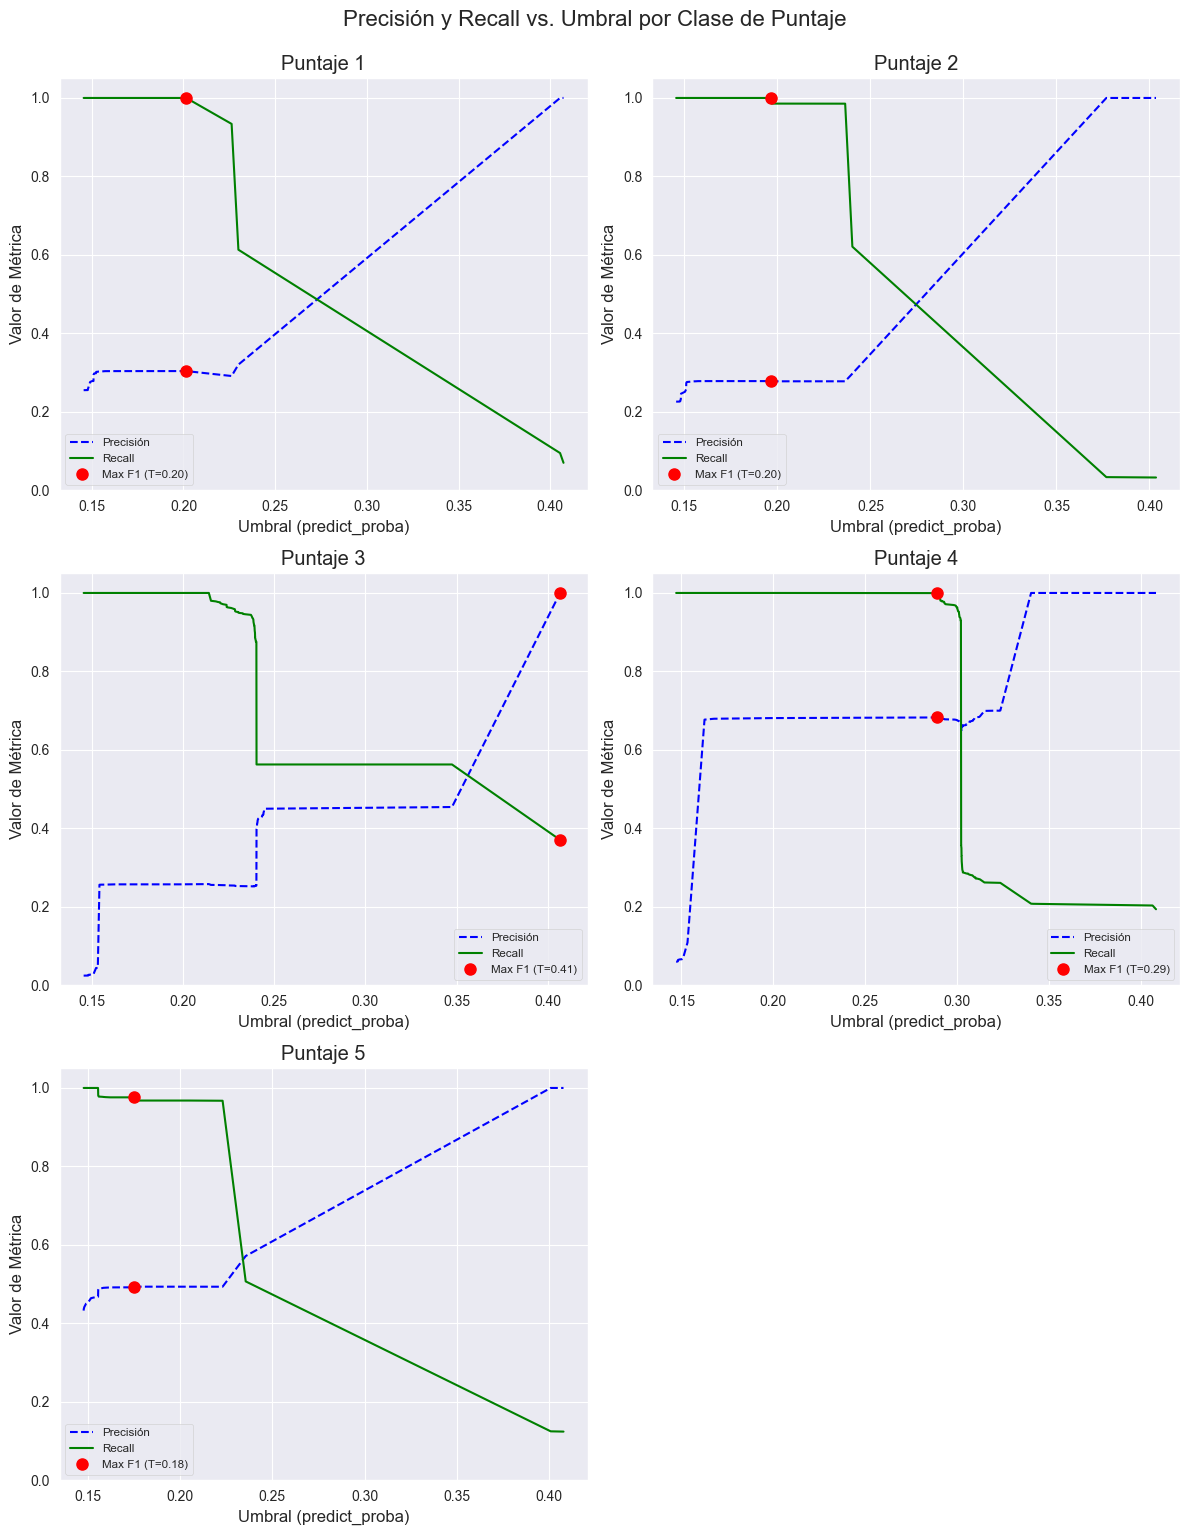


Análisis de umbrales completado.


In [128]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Clases (puntajes) que tiene tu modelo
# Asegúrate de que esto coincida con pipelines.classes_
# Por ejemplo, si tus clases son [1, 2, 3, 4, 5]
clases_del_modelo = sorted(np.unique(y_test)) # O directamente pipelines.classes_
if not np.array_equal(np.sort(pipelines.classes_ + 1), np.sort(clases_del_modelo)):
    print("Advertencia: pipelines.classes_ no coincide con las clases únicas en y_test.")
    print(f"pipelines.classes_: {pipelines.classes_}")
    print(f"Clases en y_test: {clases_del_modelo}")
    # Podrías querer usar pipelines.classes_ como la fuente autoritativa
    clases_del_modelo = pipelines.classes_ + 1

n_cols = 2
n_rows = 3 # Suficiente para 5 clases (2*3 = 6 plots)

# Crear la figura y los ejes para los subgráficos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 15)) # Ajusta figsize según necesites
axes = axes.flatten() # Aplanar el array de ejes para iterar fácilmente

print("Generando gráficos de Precisión y Recall vs. Umbral por clase...")

for i, clase_objetivo in enumerate(clases_del_modelo):
    ax = axes[i] # Seleccionar el eje actual

    # Encuentra el índice de columna correspondiente a la clase objetivo en y_proba_test
    try:
        idx_clase_objetivo_en_proba = np.where(pipelines.classes_ +1 == clase_objetivo)[0][0]
    except IndexError:
        print(f"Error: La clase {clase_objetivo} no se encontró en pipelines.classes_ ({pipelines.classes_}). Omitiendo este gráfico.")
        ax.set_title(f"Puntaje {clase_objetivo} (Datos no encontrados)")
        ax.axis('off') # Ocultar ejes si no hay datos
        continue

    # Binariza y_test para la clase objetivo (One-vs-Rest)
    y_test_binarized_clase_objetivo = (y_test == clase_objetivo).astype(int)

    # Obtén las probabilidades solo para la clase objetivo
    y_scores_clase_objetivo = y_proba_test[:, idx_clase_objetivo_en_proba]

    # Calcula precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(
        y_test_binarized_clase_objetivo,
        y_scores_clase_objetivo
    )

    # Graficar Precision y Recall vs. Threshold
    ax.plot(thresholds, precision[:-1], "b--", label="Precisión")
    ax.plot(thresholds, recall[:-1], "g-", label="Recall")
    ax.set_xlabel(f"Umbral (predict_proba)")
    ax.set_ylabel("Valor de Métrica")
    ax.set_title(f"Puntaje {clase_objetivo}")
    ax.legend(loc="best") # "center right" puede ser mejor si las curvas se superponen mucho
    ax.grid(True)
    ax.set_ylim([0, 1.05])

    # (Opcional) Encontrar y marcar puntos de interés en cada subgráfico
    # F1-score máximo
    f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
    if len(f1_scores) > 0: # Asegurarse de que no esté vacío
        optimal_idx_f1 = np.argmax(f1_scores)
        optimal_threshold_f1 = thresholds[optimal_idx_f1]
        # Marcar el punto en el gráfico
        ax.plot(optimal_threshold_f1, precision[optimal_idx_f1], 'ro', markersize=8, label=f'Max F1 (T={optimal_threshold_f1:.2f})')
        ax.plot(optimal_threshold_f1, recall[optimal_idx_f1], 'ro', markersize=8)
        ax.legend(loc="best", fontsize='small') # Actualizar leyenda

    print(f"  Gráfico para Puntaje {clase_objetivo} generado.")

# Ocultar ejes de subgráficos no utilizados (si el número de clases es menor que n_rows*n_cols)
for j in range(i+1, n_rows * n_cols):
    fig.delaxes(axes[j]) # O axes[j].axis('off')

plt.tight_layout() # Ajustar espaciado para evitar superposiciones de títulos/etiquetas
plt.suptitle("Precisión y Recall vs. Umbral por Clase de Puntaje", fontsize=16, y=1.02) # Título general
plt.show()

print("\nAnálisis de umbrales completado.")